In [65]:
# ==========================================
# CELL 1: SETUP & RESUME LOGIC
# ==========================================
import json
import pickle
import time
import os
import networkx as nx
import hashlib
from tqdm.notebook import tqdm
from groq import Groq
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict


load_dotenv(override=True)
client = Groq(api_key=os.environ["GROQ_API_KEY"])

# --- CONFIGURATION (CHANGE THIS MANUALLY) ---
# CURRENT_MODEL = "llama-3.3-70b-versatile" # 100k TPD
# CURRENT_MODEL = "openai/gpt-oss-120b" # 200k TPD

# CURRENT_MODEL = "moonshotai/kimi-k2-instruct" #  300k TPD - 32B
# CURRENT_MODEL = "moonshotai/kimi-k2-instruct-0905" # 300k TPD - 32B
# CURRENT_MODEL = "qwen/qwen3-32b" # 500k TPD - 32B

# CURRENT_MODEL = "openai/gpt-oss-20b" # 200k TPD 

# CURRENT_MODEL = "meta-llama/llama-4-maverick-17b-128e-instruct" # 500k TPD
CURRENT_MODEL = "meta-llama/llama-4-scout-17b-16e-instruct" # 500k TPD


# SESSION_TOKEN_LIMIT = 90_000 # llama 70b - 20k for failed chunks 
# SESSION_TOKEN_LIMIT = 180_000 # oss-120b (20k for failed chunks) and oss-20b
# SESSION_TOKEN_LIMIT = 301_000 # kimi k2 models 
SESSION_TOKEN_LIMIT = 550_000 # qwen 32b and meta models

# --- PATHS ---
GRAPH_PATH = "./models/knowledge_graph.pkl"
PROCESSED_LOG_PATH = "./models/processed_chunks.json"
CHUNKS_PATH = "./models/chunk_metadata.pkl"
FAILED_LOG_PATH = "./models/failed_chunks.json"

# --- LOAD RESOURCES ---
with open(CHUNKS_PATH, "rb") as f:
    chunks = pickle.load(f)

if os.path.exists(GRAPH_PATH):
    print(f"📂 Found existing graph at {GRAPH_PATH}. Loading...")
    with open(GRAPH_PATH, "rb") as f:
        kg = pickle.load(f)
else:
    print("🆕 No existing graph found. Creating new empty graph.")
    kg = nx.DiGraph()

if os.path.exists(PROCESSED_LOG_PATH):
    with open(PROCESSED_LOG_PATH, "r") as f:
        processed_ids = set(json.load(f))
    print(f"📝 Found log: {len(processed_ids)} chunks already processed.")
else:
    processed_ids = set()
    print("📝 No log found. Starting fresh.")

if os.path.exists(FAILED_LOG_PATH):
    with open(FAILED_LOG_PATH, "r") as f:
        failed_ids = set(json.load(f))
        print(f"❌ Found log: {len(failed_ids)} chunks failed.")
else:
    failed_ids = set()
    print("❌ No failed log found. Starting fresh.")
    
def get_chunk_id(text):
    return hashlib.md5(text.encode()).hexdigest()

print(f"✅ Setup Complete. Ready to use model: {CURRENT_MODEL}")

📂 Found existing graph at ./models/knowledge_graph.pkl. Loading...
📝 Found log: 38936 chunks already processed.
❌ Found log: 0 chunks failed.
✅ Setup Complete. Ready to use model: meta-llama/llama-4-scout-17b-16e-instruct


In [66]:
# CELL 2: EXTRACTION ENGINE
# ==========================================
def extract_triples(text, model_name):
    """
    Returns: (list_of_triples, total_tokens_used)
    Raises exception if API fails.
    """
    system_prompt = """
    You are a Knowledge Graph extractor. 
    Task: Extract key facts from the text as Subject-Predicate-Object triples.
    
    Rules:
    1. Subject and Object must be specific entities (People, Places, Dates).
    2. Predicate should be a short verb phrase (e.g., "released", "located_in").
    3. Output MUST be valid JSON only. No markdown formatting. No preamble.
    4. Format: {"triples": [{"head": "Subject", "type": "Relation", "tail": "Object"}, ...]}
    """

    completion = client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": text}
        ],
        model=model_name,
        temperature=0,
        response_format={"type": "json_object"}
    )

    content = completion.choices[0].message.content
    result = json.loads(content)
    triples = result.get("triples", [])

    usage = completion.usage
    total_tokens = usage.total_tokens
    
    return triples, total_tokens

print("✅ Extractor Function.")

✅ Extractor Function.


In [67]:
# ==========================================
# CELL 3: BUILD GRAPH 
# ==========================================
# --- CONFIGURATION ---
# TARGET_RPM = 30           # llama-70b, oss-120b, oss-20b and meta models  (30)
TARGET_RPM = 60           # kimi k2 models, qwen (60)       
SAVE_EVERY_N = 10         
SAFETY_BUFFER = 1000      # Stop if we are within 1000 tokens of the limit
FAILED_LOG_PATH = "./models/failed_chunks.json"

# Metrics
session_tokens = 0
chunks_processed_this_run = 0
request_interval = 60.0 / TARGET_RPM

print(f"🚀 STARTING EXTRACTION LOOP")
print(f"   • Model: {CURRENT_MODEL}")
print(f"   • Stop Limit: {SESSION_TOKEN_LIMIT}")
print("-" * 40)

try:
    pbar = tqdm(chunks)
    for doc in pbar:
        text = doc['text']
        c_id = get_chunk_id(text)
        
        # SKIP Logic
        if c_id in processed_ids:
            continue
            
        # STOP Logic (Soft Limit)
        if session_tokens >= (SESSION_TOKEN_LIMIT - SAFETY_BUFFER):
            print(f"🛑 SESSION LIMIT REACHED (Counter says {session_tokens}). Stopping safely.")
            break

        # RATE LIMITING
        time.sleep(request_interval)
            
        # EXTRACTION ATTEMPT
        try:
            triples, tokens = extract_triples(text, CURRENT_MODEL)
            
            # Valid Extraction Logic
            valid_count = 0
            for item in triples:
                subj = item.get('head')
                obj = item.get('tail')
                rel = item.get('type')
                if not subj or not obj or not rel: continue
                kg.add_node(subj, type="entity")
                kg.add_node(obj, type="entity")
                kg.add_edge(subj, obj, relation=rel)
                valid_count += 1
            
            # Update State
            processed_ids.add(c_id)
            session_tokens += tokens
            chunks_processed_this_run += 1
            if c_id in failed_ids: failed_ids.remove(c_id)

            pbar.set_description(f"Tok/Chunks:{session_tokens} / {chunks_processed_this_run} = {session_tokens/chunks_processed_this_run:.2f} | Nodes / Edges: {kg.number_of_nodes()} / {kg.number_of_edges()} = {kg.number_of_edges()/kg.number_of_nodes():.2f} Failed:{len(failed_ids)}")

        except Exception as e:
            error_msg = str(e)
            # --- CRITICAL: CHECK FOR RATE LIMIT ---
            if "429" in error_msg or "rate_limit_exceeded" in error_msg:
                print(f"\n🚨 ACTUAL API LIMIT HIT (429).")
                print(f"   Groq Message: {error_msg}")
                used_match = re.search(r"Used (\d+)", error_msg)
                if used_match:
                    real_usage = int(used_match.group(1))
                    print(f"   💡 Real Usage Today: {real_usage}")
                print(f"🛑 STOPPING LOOP IMMEDIATELY TO PREVENT SPAM. chunk {c_id}")
                break 
            if "json_validate_failed" in error_msg:
                print(f"⚠️ JSON Error on chunk {c_id}")
            else:
                print(f"⚠️ API Error on chunk {c_id}: {e}")
            
            failed_ids.add(c_id)
        
        # CHECKPOINT SAVE
        if chunks_processed_this_run % SAVE_EVERY_N == 0:
            with open(GRAPH_PATH, "wb") as f: pickle.dump(kg, f)
            with open(PROCESSED_LOG_PATH, "w") as f: json.dump(list(processed_ids), f)
            with open(FAILED_LOG_PATH, "w") as f: json.dump(list(failed_ids), f)

except KeyboardInterrupt:
    print("\n👋 User interrupted.")

# --- FINAL SAVE ---
print("\n💾 Saving Final State...")
with open(GRAPH_PATH, "wb") as f: pickle.dump(kg, f)
with open(PROCESSED_LOG_PATH, "w") as f: json.dump(list(processed_ids), f)
with open(FAILED_LOG_PATH, "w") as f: json.dump(list(failed_ids), f)

print("-" * 40)
print("✅ RUN PAUSED/COMPLETED")
print(f"   • Chunks Processed This Run: {chunks_processed_this_run}")
print(f"   • Total Chunks Processed: {len(processed_ids)}")
print(f"   • Total Chunks Failed: {failed_ids}")
print("-" * 40)

🚀 STARTING EXTRACTION LOOP
   • Model: meta-llama/llama-4-scout-17b-16e-instruct
   • Stop Limit: 550000
----------------------------------------


  0%|          | 0/39141 [00:00<?, ?it/s]


💾 Saving Final State...
----------------------------------------
✅ RUN PAUSED/COMPLETED
   • Chunks Processed This Run: 152
   • Total Chunks Processed: 39088
   • Total Chunks Failed: set()
----------------------------------------


In [68]:
# Notifier
import subprocess

def notify_finish(title="Task Complete", message="Your model training is finished.", speak=True):
    """
    Triggers a native macOS notification and optional voice alert.
    """
    # 1. VISUAL: Create the AppleScript for the Notification Banner
    # We use 'sound name "Glass"' to get the standard notification "ding"
    safe_title = title.replace('"', '\\"')
    safe_message = message.replace('"', '\\"')
    apple_script = f'display notification "{safe_message}" with title "{safe_title}" sound name "Glass"'
    
    subprocess.run(['osascript', '-e', apple_script])

    # 2. AUDIO: Speak the message (useful if watching a movie)
    if speak:
        # The 'say' command is built into macOS
        subprocess.run(['say', f"{title}. {message}"])

# Quick test to confirm volume and permissions
# notify_finish("Graph Builder", "Done.")
notify_finish("Graph Builder", "Done.", speak=False)

📊 KNOWLEDGE GRAPH STATISTICS
🔹 Total Nodes (Entities):   311,236
🔹 Total Edges (Relations):  374,312
🔹 Graph Density:            0.00000 (Higher = more interconnected)
🔹 Avg Connections per Node: 1.20

🏆 TOP 5 MOST CONNECTED ENTITIES
   1. United States (1907 connections)
   2. France (984 connections)
   3. London (891 connections)
   4. Greece (844 connections)
   5. Egypt (836 connections)

🔗 TOP 5 RELATIONSHIP TYPES
located_in      14996
includes         2411
part_of          2366
occurred_in      1918
published_in     1918

🎨 Visualizing top 100 nodes...


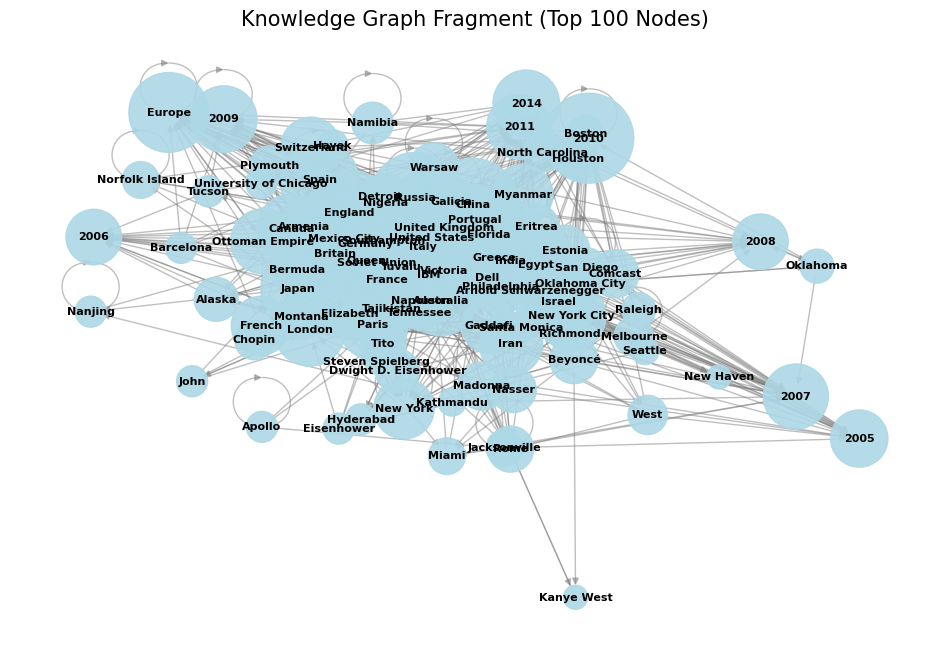

In [69]:
# CELL 4: GRAPH ANALYTICS & VISUALIZATION
# ==========================================
def analyze_and_visualize(G, viz_limit=50):
    if G.number_of_nodes() == 0:
        print("⚠️ Graph is empty. Run Cell 3 to extract data first!")
        return

    # --- PART 1: NUMERIC STATISTICS ---
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    
    # Calculate degrees (connections)
    degrees = dict(G.degree())
    sorted_nodes = sorted(degrees.items(), key=lambda item: item[1], reverse=True)
    
    # Top 5 "Central" Nodes (Most mentioned entities)
    top_5 = sorted_nodes[:5]
    
    # Analyze Relations (Predicates)
    # We extract all edge attributes to see what kind of relationships we found
    all_relations = [d['relation'] for u, v, d in G.edges(data=True)]
    relation_counts = pd.Series(all_relations).value_counts().head(5)

    print(f"📊 KNOWLEDGE GRAPH STATISTICS")
    print(f"==============================")
    print(f"🔹 Total Nodes (Entities):   {num_nodes:,}")
    print(f"🔹 Total Edges (Relations):  {num_edges:,}")
    print(f"🔹 Graph Density:            {density:.5f} (Higher = more interconnected)")
    print(f"🔹 Avg Connections per Node: {num_edges / num_nodes:.2f}")
    print(f"\n🏆 TOP 5 MOST CONNECTED ENTITIES")
    for i, (node, count) in enumerate(top_5, 1):
        print(f"   {i}. {node} ({count} connections)")
        
    print(f"\n🔗 TOP 5 RELATIONSHIP TYPES")
    print(relation_counts.to_string())
    print(f"==============================\n")

    # --- PART 2: VISUALIZATION ---
    print(f"🎨 Visualizing top {viz_limit} nodes...")
    plt.figure(figsize=(12, 8))
    
    # Subgraph of top nodes only
    top_node_names = [n[0] for n in sorted_nodes[:viz_limit]]
    subgraph = G.subgraph(top_node_names)
    
    # Layout (Spring layout tends to push connected nodes together)
    # k=0.5 controls the distance between nodes
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)
    
    # Draw Nodes
    # Size depends on degree (more connections = bigger circle)
    node_sizes = [subgraph.degree(n) * 100 for n in subgraph.nodes()]
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color='lightblue', alpha=0.9)
    
    # Draw Edges
    nx.draw_networkx_edges(subgraph, pos, edge_color='gray', alpha=0.5, arrows=True)
    
    # Draw Labels
    nx.draw_networkx_labels(subgraph, pos, font_size=8, font_weight="bold")
    
    # Draw Edge Labels (Relations) - Only if not too cluttered
    if viz_limit <= 30:
        edge_labels = nx.get_edge_attributes(subgraph, 'relation')
        nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=6)
    
    plt.title(f"Knowledge Graph Fragment (Top {viz_limit} Nodes)", fontsize=15)
    plt.axis('off') # Hide axis numbers
    plt.show()

# Run the Analysis
analyze_and_visualize(kg, viz_limit=100)

In [70]:
# GRAPH MRI SCANNER
# ==========================================
# 1. LOAD THE BRAIN
GRAPH_PATH = "./models/knowledge_graph.pkl"
print(f"📂 Loading Graph from {GRAPH_PATH}...")

with open(GRAPH_PATH, "rb") as f:
    G = pickle.load(f)

print(f"✅ Graph Loaded. Nodes: {G.number_of_nodes():,} | Edges: {G.number_of_edges():,}")
print("-" * 60)

# 2. DEGREE DISTRIBUTION (The Mathematics of Connectivity)
degrees = [d for n, d in G.degree()]
in_degrees = [d for n, d in G.in_degree()]
out_degrees = [d for n, d in G.out_degree()]

print("📊 CONNECTIVITY STATISTICS")
print(f"   • Average Connections per Node: {np.mean(degrees):.2f}")
print(f"   • Median Connections:           {np.median(degrees):.1f}")
print(f"   • Max Degree (The King Node):   {np.max(degrees)}")
print(f"   • Isolated Nodes (Degree=0):    {degrees.count(0)}")

# 3. SUPER-NODE DETECTION (The 99% Cutoff)
# We define a "Super Node" as anything in the top 1% or 0.5% of connectivity.
p95 = np.percentile(degrees, 95)
p99 = np.percentile(degrees, 99)
p99_9 = np.percentile(degrees, 99.9)

print("-" * 60)
print("🛑 SUPER-NODE THRESHOLDS")
print(f"   • Top 5% Cutoff:   > {p95:.1f} connections")
print(f"   • Top 1% Cutoff:   > {p99:.1f} connections")
print(f"   • Top 0.1% Cutoff: > {p99_9:.1f} connections")
print(f"\n   👉 RECOMMENDATION: Set SUPER_NODE_THRESHOLD = {int(p99)}")

# 4. IDENTIFYING THE "BLACK HOLES"
# Let's see exactly WHO these super-nodes are.
sorted_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)
super_nodes = [n for n in sorted_nodes if n[1] > p99]

print("-" * 60)
print(f"💣 LIST OF POTENTIAL 'BLACK HOLES' (Top {len(super_nodes)} Nodes)")
print("   (These are nodes we might need to blacklist or filter)")
print(pd.DataFrame(super_nodes[:20], columns=["Entity", "Connections"]))

# 5. RELATIONSHIP AUDIT (Finding the "Junk")
# We check which verbs are most common. If "is" appears 5000 times, we ban it.
edge_attrs = nx.get_edge_attributes(G, "relation")
relation_counts = Counter(edge_attrs.values())
df_rel = pd.DataFrame(relation_counts.most_common(20), columns=["Relation", "Count"])

print("-" * 60)
print("🔗 TOP 20 RELATIONSHIPS (Candidates for Stop-List)")
print(df_rel)

# 6. ENTITY TYPE AUDIT (If available)
# Checking what kind of things we have (Person, Place, etc.) if extracted
node_types = nx.get_node_attributes(G, "type")
if node_types:
    type_counts = Counter(node_types.values())
    print("-" * 60)
    print("🏷️ TOP ENTITY TYPES")
    print(pd.DataFrame(type_counts.most_common(10), columns=["Type", "Count"]))
else:
    print("\n⚠️ No 'type' attribute found on nodes (Standard for pure extraction).")

print("-" * 60)
print("✅ SCAN COMPLETE")

📂 Loading Graph from ./models/knowledge_graph.pkl...
✅ Graph Loaded. Nodes: 311,236 | Edges: 374,312
------------------------------------------------------------
📊 CONNECTIVITY STATISTICS
   • Average Connections per Node: 2.41
   • Median Connections:           1.0
   • Max Degree (The King Node):   1907
   • Isolated Nodes (Degree=0):    0
------------------------------------------------------------
🛑 SUPER-NODE THRESHOLDS
   • Top 5% Cutoff:   > 6.0 connections
   • Top 1% Cutoff:   > 17.0 connections
   • Top 0.1% Cutoff: > 134.0 connections

   👉 RECOMMENDATION: Set SUPER_NODE_THRESHOLD = 17
------------------------------------------------------------
💣 LIST OF POTENTIAL 'BLACK HOLES' (Top 2919 Nodes)
   (These are nodes we might need to blacklist or filter)
                   Entity  Connections
0           United States         1907
1                  France          984
2                  London          891
3                  Greece          844
4                   Egypt      

In [71]:
# DUPLICATE DETECTOR
# ==========================================
# 1. Group chunks by their ID
id_map = defaultdict(list)

print("🕵️‍♂️ Scanning for duplicates...")
for i, doc in enumerate(chunks):
    text = doc['text']
    c_id = hashlib.md5(text.encode()).hexdigest()
    id_map[c_id].append(i)

# 2. Find IDs that appear more than once
duplicates = {k: v for k, v in id_map.items() if len(v) > 1}

print(f"📊 Analysis Complete:")
print(f"   • Total Chunks: {len(chunks)}")
print(f"   • Unique IDs:   {len(id_map)}")
print(f"   • Duplicate IDs found: {len(duplicates)}")

if len(duplicates) > 0:
    print("\n🔍 Example of a Duplicate:")
    sample_id = list(duplicates.keys())[0]
    indices = duplicates[sample_id]
    print(f"   ID: {sample_id} appears at indices {indices}")
    print(f"   Text 1: {chunks[indices[0]]['text'][:50]}...")
    print(f"   Text 2: {chunks[indices[1]]['text'][:50]}...")
    
    if chunks[indices[0]]['text'] == chunks[indices[1]]['text']:
        print("\n✅ CONFIRMED: The text is identical.")
    else:
        print("\n⚠️ WARNING: Actual Hash Collision! (This would be historic news)")

🕵️‍♂️ Scanning for duplicates...
📊 Analysis Complete:
   • Total Chunks: 39141
   • Unique IDs:   39088
   • Duplicate IDs found: 52

🔍 Example of a Duplicate:
   ID: 1596784390e2ee56b4f90496418b3f6b appears at indices [274, 305]
   Text 1: . Laird writes that Tibetans eagerly sought Ming c...
   Text 2: . Laird writes that Tibetans eagerly sought Ming c...

✅ CONFIRMED: The text is identical.
